In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import os
import glob
import sqlite3

In [74]:
cleaned_data = pd.read_csv('../datasets/merged_data.csv', index_col=False)
# cleaned_data = cleaned_data.drop(columns=['humidity_b','temperature_b', 'pressure_b'])
cleaned_data['time_stamp'] = pd.to_datetime(cleaned_data['time_stamp'])
cleaned_data.set_index('time_stamp', inplace=True)
cleaned_data.sort_index(inplace=True)

<Axes: xlabel='time_stamp'>

<Figure size 2000x1000 with 0 Axes>

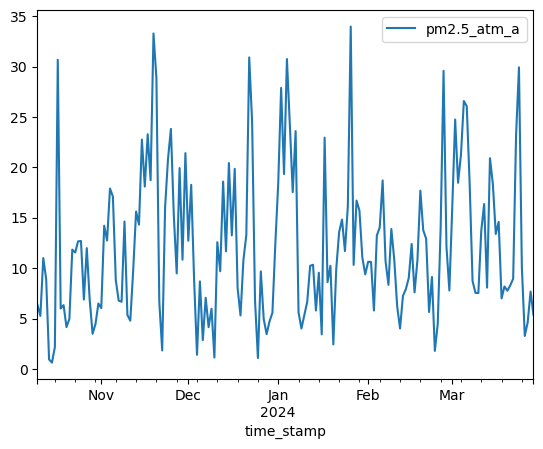

In [96]:
# choose a random sensor
random_sensor = np.random.choice(cleaned_data['sensor_index'].unique())

# plot the data
plt.figure(figsize=(20,10))
chosen_data = cleaned_data[cleaned_data['sensor_index'] == random_sensor]

columns_to_plot = ['pm2.5_atm_a']
chosen_data[columns_to_plot].plot()

In [103]:
chosen_data_1= chosen_data[['pm2.5_atm_a']]

In [104]:
chosen_data_1.reset_index(drop=False, inplace=True)
# make time_stamp datetime
chosen_data_1['time_stamp'] = pd.to_datetime(chosen_data_1['time_stamp'])
chosen_data_1

/tmp/ipykernel_943598/3527228027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_data_1['time_stamp'] = pd.to_datetime(chosen_data_1['time_stamp'])


,time_stamp,pm2.5_atm_a
0,2023-10-10,6.355
1,2023-10-11,5.265
2,2023-10-12,11.000
3,2023-10-13,8.920
4,2023-10-14,0.947
...,...,...
167,2024-03-25,10.064
168,2024-03-26,3.279
169,2024-03-27,4.622
170,2024-03-28,7.680


In [105]:
chosen_data_1.dtypes

time_stamp     datetime64[ns]
pm2.5_atm_a           float64
dtype: object

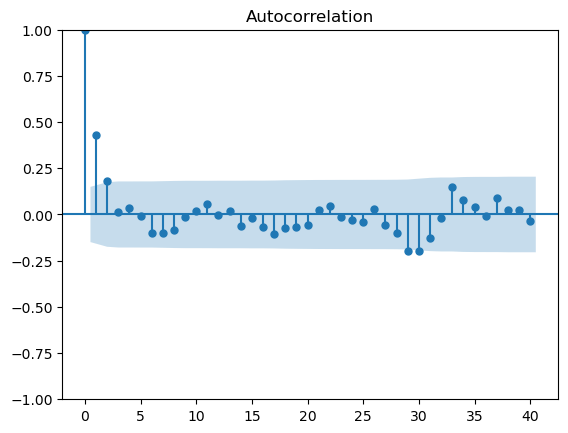

In [106]:
import statsmodels.api as sm
del chosen_data_1["time_stamp"]
sm.graphics.tsa.plot_acf(chosen_data_1.values.squeeze(), lags=40)
plt.show()


ACF only significant for lag 1. ACF is often used to determine the order of moving average in ARMA models. 

This suggests an MA of order 1 might be appropriate. 

AUGMENTED DICKEY-FULLER TEST to check for stationarity.

In [113]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
result = adf_test(chosen_data['pm2.5_atm_a'])

Results of Dickey-Fuller Test:
Test Statistic                -8.192365e+00
p-value                        7.607350e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.710000e+02
Critical Value (1%)           -3.469181e+00
Critical Value (5%)           -2.878595e+00
Critical Value (10%)          -2.575863e+00
dtype: float64


IN adfuller, null hypothesis is the data is non-stationary


So we can safely reject the null hypothesis in favor of alternate hypothesis " the time series data we have is stationary"

No differencing is needed ( d= 0)

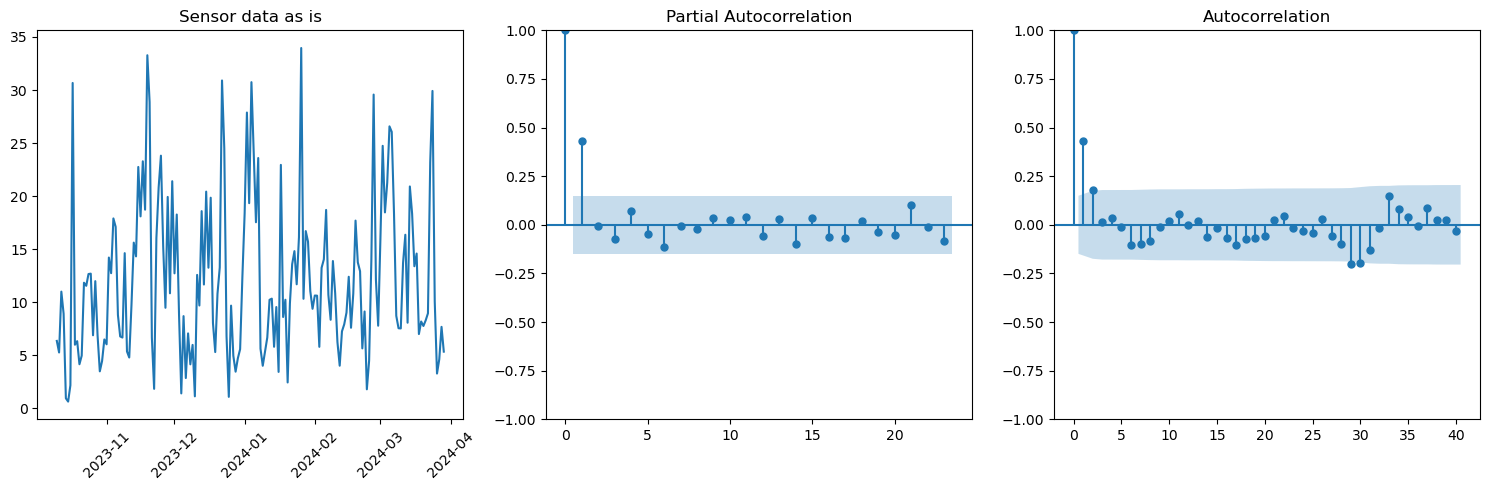

In [117]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

# Create three subplots in a single row
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot on ax1
ax1.set_title('Sensor data as is')
ax1.plot(chosen_data['pm2.5_atm_a'])
ax1.xaxis.set_tick_params(rotation=45)

# Plot Partial Autocorrelation Function on ax2
plot_pacf(chosen_data['pm2.5_atm_a'].dropna(), ax=ax2)

# Plot Autocorrelation Function on ax3
sm.graphics.tsa.plot_acf(chosen_data_1.values.squeeze(), lags=40, ax=ax3)

plt.tight_layout()
plt.show()

lag of 1 is appropriate. SO AR(1) model may be appropriate